In [12]:
import pandas as pd
import numpy as np
from freesurfer_stats import CorticalParcellationStats
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
## Tabular Data
project_dir = "../"
metadata_dir = f"{project_dir}/metadata/"
data_dir = "/home/nikhil/projects/brain_changes/data/"

freesurfer_fields = f"{metadata_dir}brainage_fs_ukbb_field_ids.csv"

# ukbb
ukbb_demograph_csv = f"{data_dir}ukbb/tabular/ukbb_follow_up_demographics.csv"
ukbb_FS_csv = f"{data_dir}ukbb/imaging/freesurfer/ukb47552_followup_subset.csv"

# adni
adni_demograph_csv = f"{data_dir}adni/metadata/ADNIMERGE.csv"
adni_FS_DKT_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_DKT.csv"
adni_FS_aseg_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_aseg.csv"

# summary results
summary_results_dir = f"{project_dir}/results/summary/ohbm2022/"

# figures
fig_dir = f"{project_dir}/results/figures/ohbm/"


## Configs

In [14]:
FS_measures = "DKT" # "DKT", "aseg", or "both"

save_fig = False

## Grab Freesurfer measures

In [15]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields)

CT_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="DKT"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["stat"]=="aseg"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

if FS_measures == "DKT":
    pheno_fields = CT_fields
elif FS_measures == "aseg":
    pheno_fields = volume_fields
else:
    pheno_fields = CT_fields.append(volume_fields)

pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"Using {FS_measures} features with 2 timepoints i.e. {len(usecols)} columns")

number of CT fields: 62, volume fields: 36
Using DKT features with 2 timepoints i.e. 125 columns


### UKBB demograph data

In [16]:
tab_data_df = pd.read_csv(ukbb_demograph_csv)
print(f"number of subjects in ukbb_demograph_data: {len(tab_data_df)}")
tab_data_df.head()

number of subjects in ukbb_demograph_data: 3202


,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment
0,1000635,1.0,1950.0,2017-12-21,2020-03-09,20252_2_0,20252_3_0,1001.0,67.0,69.0,58.0
1,1004084,1.0,1947.0,2017-05-23,2019-10-23,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0
2,1008391,1.0,1955.0,2017-10-13,2021-02-17,20252_2_0,20252_3_0,1001.0,62.0,65.0,54.0
3,1010063,0.0,1964.0,2017-07-05,2019-10-29,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0
4,1010129,0.0,1947.0,2017-08-16,2019-11-17,20252_2_0,20252_3_0,1001.0,69.0,71.0,60.0


### UKBB Freesurfer data

In [17]:
print(f"reading {len(usecols)} columes")
ukbb_freesurfer_df = pd.read_csv(ukbb_FS_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = ukbb_freesurfer_df[ukbb_freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

ukbb_freesurfer_df = ukbb_freesurfer_df[~ukbb_freesurfer_df["eid"].isin(eid_missing_data)]
freesurfer_eids = ukbb_freesurfer_df["eid"].values

print(f"available freesurfer subjects: {len(freesurfer_eids)}")
ukbb_freesurfer_df = ukbb_freesurfer_df.rename(columns={"eid":"subject_id"})
ukbb_freesurfer_df = ukbb_freesurfer_df.set_index("subject_id")

## Some outlier that need to be looked at (most likely proc failures)
drop_subjects = [1293173] #1293173 --> super high CT change

ukbb_freesurfer_df = ukbb_freesurfer_df.drop(drop_subjects)

# Split visits
BL_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses2]
BL_ukbb_freesurfer_df = BL_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses2, pheno_fields)))
FU_ukbb_freesurfer_df = ukbb_freesurfer_df[pheno_cols_ses3]
FU_ukbb_freesurfer_df = FU_ukbb_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses3, pheno_fields)))

print(f"BL shape: {BL_ukbb_freesurfer_df.shape}, FU shape: {FU_ukbb_freesurfer_df.shape}")

print(f"Number dropped subjects: {len(drop_subjects)}")

ukbb_freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63
available freesurfer subjects: 3237
BL shape: (3236, 62), FU shape: (3236, 62)
Number dropped subjects: 1


,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,27178-3.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
subject_id,,,,,,,,,,,,,,,,,,,,,
1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,2.815,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,2.753,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,2.801,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,2.678,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,2.949,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


### ADNI metadata

In [18]:
adnimerge_df = pd.read_csv(adni_demograph_csv)
print(f"ADNIMERGE len: {len(adnimerge_df)}")

adnimerge_df["subject_id"] = "sub-ADNI" + adnimerge_df["PTID"]
adnimerge_df["subject_id"] = adnimerge_df["subject_id"].str.replace("_","")

useful_cols = ["subject_id","DX_bl","AGE","PTGENDER","VISCODE"]
adnimerge_dx_df = adnimerge_df[(adnimerge_df["VISCODE"]=="bl")][useful_cols]

print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")
adnimerge_dx_df.head()

ADNIMERGE len: 11483
adnimerge with longitudinal subjects. n_subjects = 1735


,subject_id,DX_bl,AGE,PTGENDER,VISCODE
0,sub-ADNI011S0002,CN,74.3,Male,bl
1,sub-ADNI011S0003,AD,81.3,Male,bl
5,sub-ADNI022S0004,LMCI,67.5,Male,bl
10,sub-ADNI011S0005,CN,73.7,Male,bl
15,sub-ADNI100S0006,LMCI,80.4,Female,bl


### ADNI Freesurfer data

In [19]:
if FS_measures == "DKT":
    adni_freesurfer_df = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
elif FS_measures == "aseg":
    adni_freesurfer_df = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")
else:
    df1 = pd.read_csv(adni_FS_DKT_csv).set_index("subject_id")
    df2 = pd.read_csv(adni_FS_aseg_csv).set_index("subject_id")

    adni_freesurfer_df = pd.concat([df1,df2],axis=1)

adni_subjects = adni_freesurfer_df.index
print(f"Number of ADNI subjects: {len(adni_subjects)}")

# Split visits
BL_adni_freesurfer_df = adni_freesurfer_df[pheno_cols_ses2]
BL_adni_freesurfer_df = BL_adni_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses2, pheno_fields)))
FU_adni_freesurfer_df = adni_freesurfer_df[pheno_cols_ses3]
FU_adni_freesurfer_df = FU_adni_freesurfer_df.rename(columns=dict(zip(pheno_cols_ses3, pheno_fields)))

print(f"BL shape: {BL_adni_freesurfer_df.shape}, FU shape: {FU_adni_freesurfer_df.shape}")


adni_freesurfer_df.head()

Number of ADNI subjects: 267
BL shape: (267, 62), FU shape: (267, 62)


,27174-2.0,27175-2.0,27176-2.0,27177-2.0,27178-2.0,27179-2.0,27180-2.0,27181-2.0,27182-2.0,27183-2.0,...,27288-3.0,27289-3.0,27290-3.0,27291-3.0,27292-3.0,27293-3.0,27294-3.0,27295-3.0,27296-3.0,27297-3.0
subject_id,,,,,,,,,,,,,,,,,,,,,
sub-ADNI019S4285,2.635,2.728,1.956,3.227,2.857,2.382,2.856,2.408,2.111,2.721,...,2.647,2.356,2.731,2.337,2.620,2.180,2.777,2.606,2.792,2.938
sub-ADNI116S4453,2.334,2.350,1.829,3.573,2.568,2.149,2.552,2.226,2.018,2.460,...,2.225,2.156,2.775,2.050,2.399,1.877,2.640,2.192,2.300,2.605
sub-ADNI116S4625,2.332,2.095,1.936,2.606,2.501,2.063,2.668,2.228,2.129,2.257,...,2.389,2.225,2.473,2.236,2.267,2.095,2.759,2.568,2.516,2.981
sub-ADNI011S4893,2.582,2.401,1.948,3.188,2.541,2.195,2.587,2.078,2.189,2.533,...,2.302,2.218,2.572,2.265,2.321,2.053,2.527,2.380,1.953,2.695
sub-ADNI037S4410,2.447,2.482,2.100,3.147,2.510,2.247,2.480,2.383,2.081,2.512,...,2.599,2.297,2.619,2.214,2.471,2.123,2.703,2.367,2.511,2.674


### Subject specific changes: avg visit differences

In [20]:
ukbb_CT_diff_df = BL_ukbb_freesurfer_df - FU_ukbb_freesurfer_df
adni_CT_diff_df = BL_adni_freesurfer_df - FU_adni_freesurfer_df

ukbb_CT_avg_diff_df = ukbb_CT_diff_df.mean(axis=1).copy().reset_index()
adni_CT_avg_diff_df = adni_CT_diff_df.mean(axis=1).copy().reset_index()

In [21]:
ukbb_CT_avg_diff_df["cohort"] = "ukbb"
ukbb_CT_avg_diff_df["DX_bl"] = "ukbb-CN"

adnimerge_dx_df = adnimerge_dx_df[(adnimerge_dx_df["subject_id"].isin(adni_subjects))]
adnimerge_dx_df["DX_bl"] = adnimerge_dx_df["DX_bl"].replace({"CN":"adni-CN"})
adni_CT_avg_diff_df["cohort"] = "adni"
adni_CT_avg_diff_df = pd.merge(adni_CT_avg_diff_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_CT_avg_diff_df = adni_CT_avg_diff_df.set_index("subject_id")

ukbb_adni_CT_avg_diff_df = pd.concat([ukbb_CT_avg_diff_df,adni_CT_avg_diff_df],axis=0)
ukbb_adni_CT_avg_diff_df = ukbb_adni_CT_avg_diff_df.rename(columns={0:"avg_change_in_CT"})

DX_counts = adnimerge_dx_df.value_counts("DX_bl")
print(f"Number of subjects, {DX_counts}")

Number of subjects, DX_bl
adni-CN    92
EMCI       86
LMCI       76
AD         13
dtype: int64


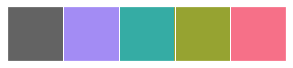

In [28]:
## Colors
pal = ["#636363"] + sns.color_palette("husl", 4)[::-1]
sns.palplot(pal)

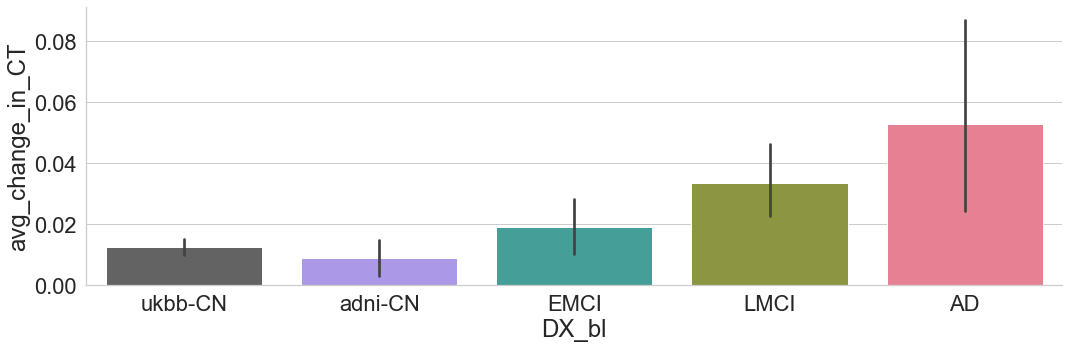

In [29]:
plot_df = ukbb_adni_CT_avg_diff_df.copy()
x_order = ["ukbb-CN","adni-CN","EMCI","LMCI","AD"]
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="DX_bl",y="avg_change_in_CT",kind="bar", aspect=3, order=x_order,data=plot_df, palette=pal)

if save_fig:
    fig_name = "Avg_change_in_CT"
    g.savefig(f"{fig_dir}/{fig_name}")

### Correlation between visits

In [30]:
adni_corr_df = BL_adni_freesurfer_df.corrwith(FU_adni_freesurfer_df,axis=1).reset_index()
ukbb_corr_df = BL_ukbb_freesurfer_df.corrwith(FU_ukbb_freesurfer_df,axis=1).reset_index()

ukbb_corr_df["cohort"] = "ukbb"
ukbb_corr_df["DX_bl"] = "ukbb-CN"

adni_corr_df["cohort"] = "adni"
adni_corr_df = pd.merge(adni_corr_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_corr_df = adni_corr_df.set_index("subject_id")

ukbb_adni_corr_df = pd.concat([ukbb_corr_df,adni_corr_df],axis=0)
ukbb_adni_corr_df = ukbb_adni_corr_df.rename(columns={0:"visit-corr"})

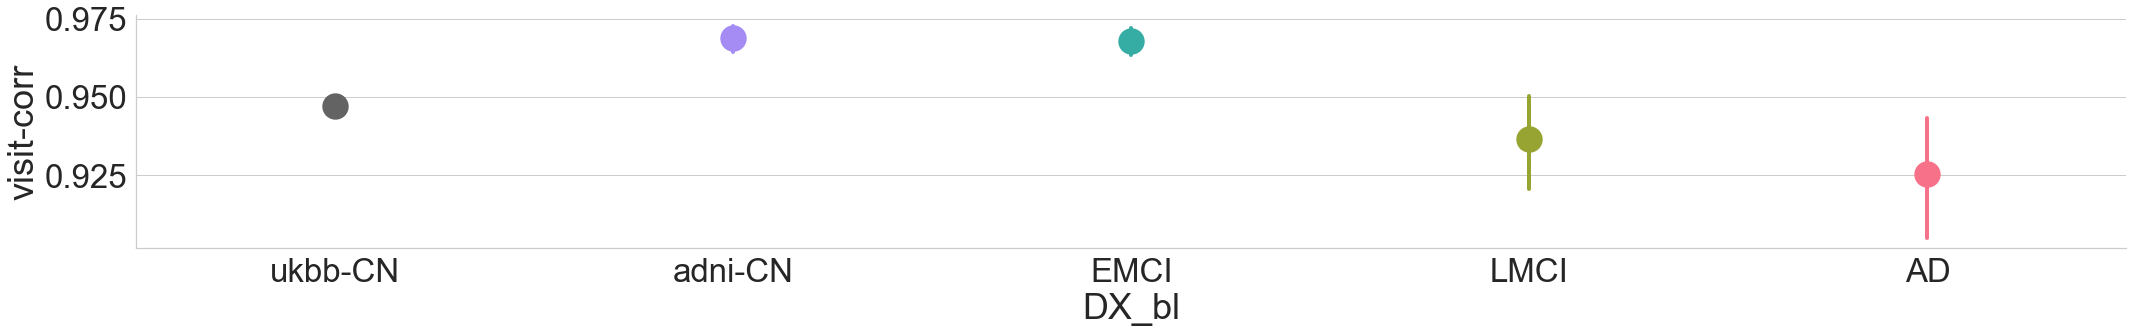

In [31]:
plot_df = ukbb_adni_corr_df.copy()
hue_order = ["ukbb-CN","adni-CN","EMCI","LMCI","AD"]

# reorder colors since point plot messes it up
myorder = [0,2,1,4,3]
pal = ["#636363"] + sns.color_palette("husl", 4)[::-1]
pal = [pal[i] for i in myorder]

sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="visit-corr",x="DX_bl", scale=3, errwidth=4, kind="point", hue="DX_bl", order=hue_order, 
    palette=pal, aspect=6, data=plot_df)
    

if save_fig:
    fig_name = "Visit-corr"
    g.savefig(f"{fig_dir}/{fig_name}")

### ROI-wise difference

In [32]:
ukbb_CT_diff_df["cohort"] = "ukbb"
ukbb_CT_diff_df["DX_bl"] = "ukbb-CN"

adni_CT_diff_df["cohort"] = "adni"
adni_CT_diff_df = pd.merge(adni_CT_diff_df, adnimerge_dx_df[["subject_id","DX_bl"]], on="subject_id")
adni_CT_diff_df = adni_CT_diff_df.set_index("subject_id")

ukbb_adni_CT_diff_df = pd.concat([ukbb_CT_diff_df,adni_CT_diff_df],axis=0).reset_index()

ukbb_adni_CT_diff_df_melt = ukbb_adni_CT_diff_df.melt(
    id_vars=["subject_id","DX_bl","cohort"],
    var_name="ROI", 
    value_name="change in CT",
)
ukbb_adni_CT_diff_df_melt.head()

,subject_id,DX_bl,cohort,ROI,change in CT
0,1000635,ukbb-CN,ukbb,27174,-0.088
1,1008391,ukbb-CN,ukbb,27174,0.316
2,1010129,ukbb-CN,ukbb,27174,0.459
3,1010994,ukbb-CN,ukbb,27174,0.204
4,1013774,ukbb-CN,ukbb,27174,-0.228


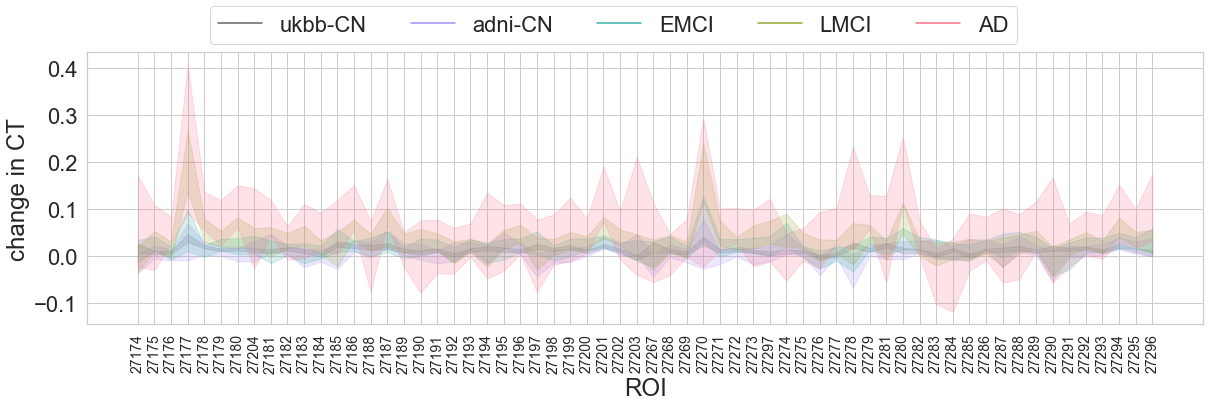

In [35]:
plot_df = ukbb_adni_CT_diff_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

pal = ["#636363"] + sns.color_palette("husl", 4)[::-1]
hue_order = ["ukbb-CN","adni-CN","EMCI","LMCI","AD"]
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    # g = sns.catplot(x="ROI",y="CT",kind="point",hue="DX_bl",hue_order=hue_order, linestyle="",palette=pal, aspect=4,data=plot_df)
    g = sns.lineplot(x="ROI",y="change in CT",hue="DX_bl",hue_order=hue_order, linestyle="",palette=pal,data=plot_df,ax=ax)
    g.tick_params(axis='x', rotation=90, labelsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(0.1, 1.1), ncol=5)

if save_fig:
    fig_name = "ROI_change_in_CT"
    plt.savefig(f"{fig_dir}/{fig_name}")

## Summary results

In [48]:
results_name = "two_visit_baseline_perf.csv"
chronage_delta_thresh = 2

perf_df = pd.read_csv(f"{summary_results_dir}{results_name}")
perf_df["Dx"] = perf_df["Dx"].replace({"CN":"adni-CN"})

perf_df.head()

,Unnamed: 0,eid,cohort,Dx,age_at_ses2,age_at_ses3,brainage_at_ses2,brainage_at_ses3,test_loss1,test_loss2,...,data_aug,baseline_err,followup_err,baseline_abs_err,followup_abs_err,brainage_delta,chronoage_delta,delta_err,delta_abs_err,Benjamin_Button
0,0,4071544,ukbb,ukbb-CN,66.0,68.0,66.838666,69.038099,0.703361,1.077649,...,False,0.838666,1.038099,0.838666,1.038099,2.199433,2.0,0.199433,0.199433,False
1,1,6005293,ukbb,ukbb-CN,61.0,63.0,64.177180,66.426670,10.094470,11.742067,...,False,3.177180,3.426670,3.177180,3.426670,2.249490,2.0,0.249490,0.249490,False
2,2,5739520,ukbb,ukbb-CN,61.0,63.0,65.219927,67.329961,17.807785,18.748565,...,False,4.219927,4.329961,4.219927,4.329961,2.110034,2.0,0.110034,0.110034,False
3,3,1308382,ukbb,ukbb-CN,51.0,53.0,61.888516,64.170480,118.559774,124.779631,...,False,10.888516,11.170480,10.888516,11.170480,2.281965,2.0,0.281965,0.281965,False
4,4,2991501,ukbb,ukbb-CN,58.0,60.0,55.281438,57.791154,7.390581,4.878999,...,False,-2.718562,-2.208846,2.718562,2.208846,2.509717,2.0,0.509717,0.509717,False


## plot MAE

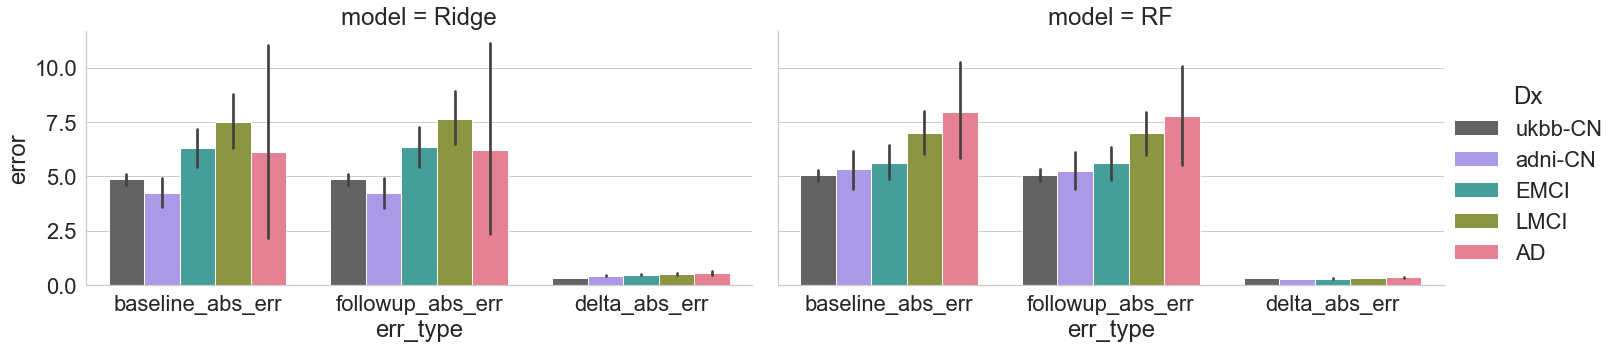

In [47]:
plot_abs_err = True

pal = ["#636363"] + sns.color_palette("husl", 4)[::-1]
hue_order = ["ukbb-CN","adni-CN","EMCI","LMCI","AD"]

plot_df = perf_df.copy()
plot_df = plot_df[plot_df["chronoage_delta"] <= chronage_delta_thresh]

plot_df_melt = plot_df.melt(id_vars=["eid","cohort", "Dx", "model", "data_aug","age_at_ses2", "brainage_at_ses2", 
"age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err','baseline_abs_err', 'followup_abs_err', 'delta_abs_err'],
              var_name='err_type', value_name='error')

if plot_abs_err:
    plot_df_melt = plot_df_melt[plot_df_melt["err_type"].isin(['baseline_abs_err', 'followup_abs_err', 'delta_abs_err'])]
else:
    plot_df_melt = plot_df_melt[plot_df_melt["err_type"].isin(['baseline_err', 'followup_err', 'delta_err'])]
    
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="err_type",y="error", hue="Dx", col="model",kind="bar", hue_order=hue_order, palette=pal,
    data=plot_df_melt, aspect=2)


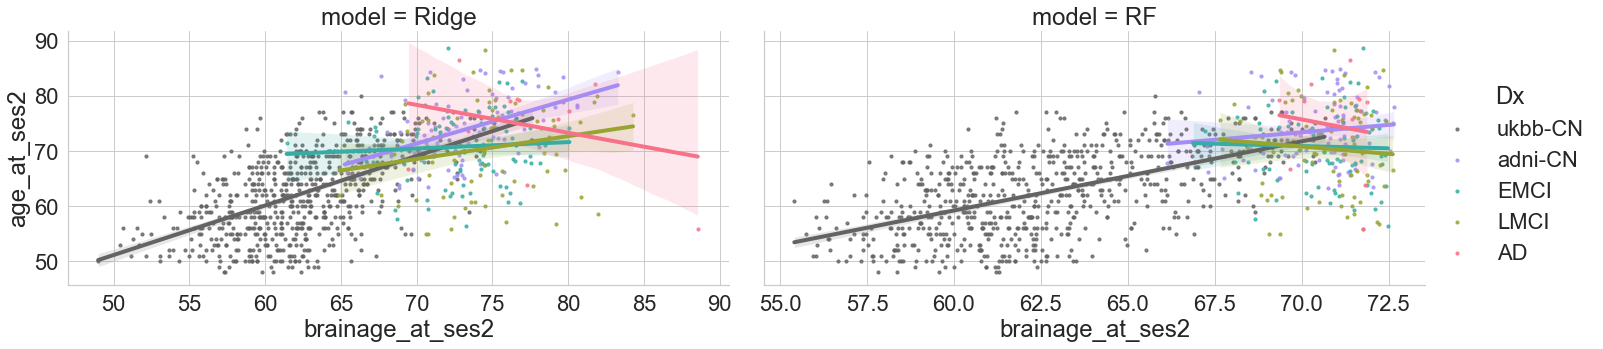

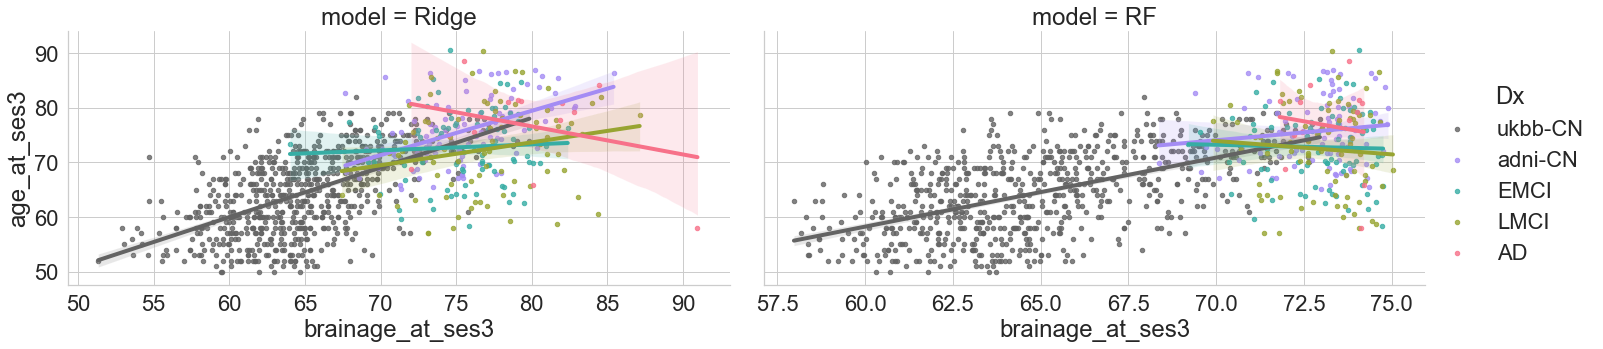

In [63]:
plot_df = perf_df.copy()
plot_df = plot_df[plot_df["chronoage_delta"] <= chronage_delta_thresh]
# plot_df = plot_df[plot_df["model"]=="Ridge"]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    # ax=axes[0]

    g = sns.lmplot(x="brainage_at_ses2", y="age_at_ses2", col="model", hue="Dx", hue_order=hue_order, scatter_kws={"s": 20},
    line_kws={"lw":4}, aspect=2, palette=pal, data=plot_df,sharex=False)
    # g.fig.suptitle("Baseline visit")

    # ax=axes[1]
    g = sns.lmplot(x="brainage_at_ses3", y="age_at_ses3", col="model", hue="Dx", hue_order=hue_order, scatter_kws={"s": 20},
    line_kws={"lw":4}, aspect=2, palette=pal, data=plot_df,sharex=False)
    # g.fig.suptitle("Followup visit")


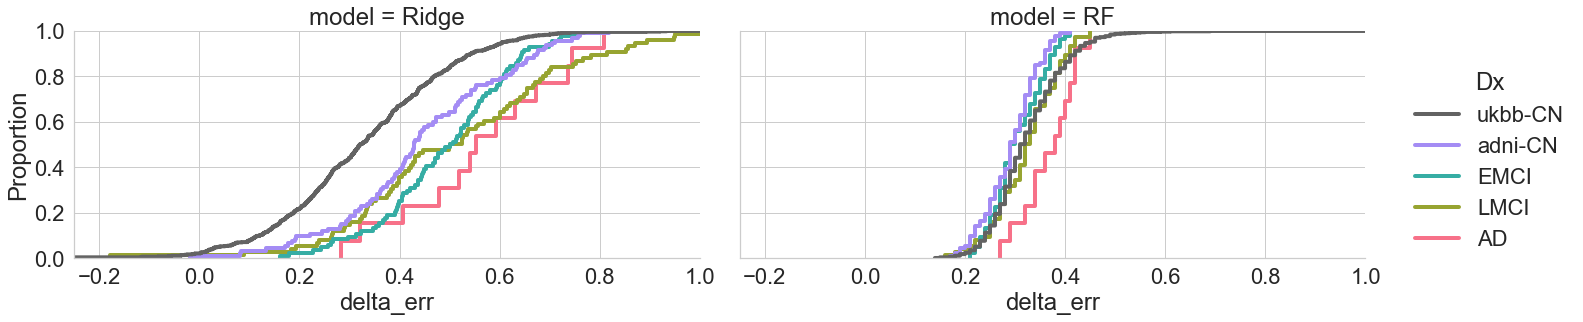

In [45]:
chronage_delta_thresh = 2

plot_df = perf_df.copy()
plot_df = plot_df[plot_df["chronoage_delta"] <= chronage_delta_thresh]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.displot(x="delta_err", col="model",hue="Dx",kind="ecdf",lw=4, aspect=2, hue_order=hue_order, palette=pal,
    data=plot_df)
    g.set(xlim=(-0.25,1))